# Advanced Lane Line Detection
#### Self Driving Car Nanodegree Course - Project 4 - Alistair S Kirk

#### Camera Calibration:

camera_cal\calibration1.jpg
camera_cal\calibration10.jpg
camera_cal\calibration11.jpg
camera_cal\calibration12.jpg
camera_cal\calibration13.jpg
camera_cal\calibration14.jpg
camera_cal\calibration15.jpg
camera_cal\calibration16.jpg
camera_cal\calibration17.jpg
camera_cal\calibration18.jpg
camera_cal\calibration19.jpg
camera_cal\calibration2.jpg
camera_cal\calibration20.jpg
camera_cal\calibration3.jpg
camera_cal\calibration4.jpg
camera_cal\calibration5.jpg
camera_cal\calibration6.jpg
camera_cal\calibration7.jpg
camera_cal\calibration8.jpg
camera_cal\calibration9.jpg
Done with imgpoints size: 17 and objpoints size: 17


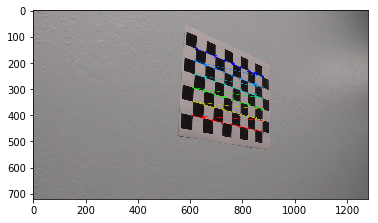

In [2]:
# Define a function for importing camera calibration images and returning camera calibration files
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import glob
import pickle

# prepare object points
nx = 9#TODO: enter the number of inside corners in x
ny = 6#TODO: enter the number of inside corners in y

#Get images
fimages = glob.glob('camera_cal/calibration*.jpg')

objpoints = [] #3D points in real world space
imgpoints = [] #2D points in image plane

#Init objpoints
objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2) # x,y coordinates

# Make a list of calibration images
for fname in fimages:
    print(fname)
    
    #convert to image
    img = cv2.imread(fname)

    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    # If found, draw corners
    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)
        
        # Draw and display the corners
        cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
        plt.imshow(img)
calib_pickle = {"objpoints": objpoints, "imgpoints": imgpoints}
pickle.dump( calib_pickle, open( "my_calib_pickle.p", "wb" ) )  

print("Done with imgpoints size: {} and objpoints size: {}".format(len(imgpoints), len(objpoints)))


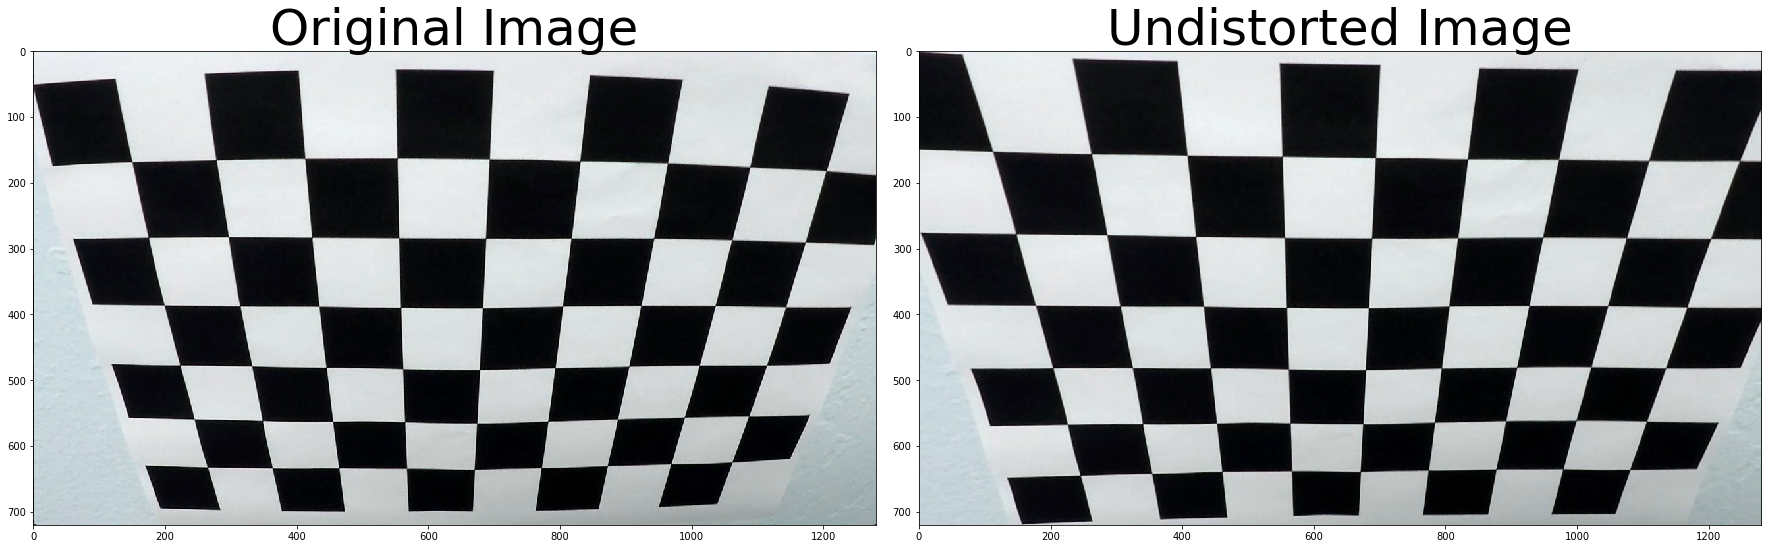

In [3]:
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Read in the saved objpoints and imgpoints
dist_pickle = pickle.load( open( "my_calib_pickle.p", "rb" ) )
objpoints = dist_pickle["objpoints"]
imgpoints = dist_pickle["imgpoints"]

# Read in an image
img = cv2.imread('camera_cal/calibration2.jpg')

# TODO: Write a function that takes an image, object points, and image points
# performs the camera calibration, image distortion correction and 
# returns the undistorted image
def cal_undistort(img, objpoints, imgpoints):
    # Use cv2.calibrateCamera() and cv2.undistort()
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[0:2],None,None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist, mtx, dist

undistorted,mtx,dst = cal_undistort(img, objpoints, imgpoints)

#Save calibrated camera matrix and dst
cam_params = {"mtx": mtx, "dst": dst}
pickle.dump( cam_params, open( "calib_cam_params.p", "wb" ) )  

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

#### Define and Test Perpective Transform

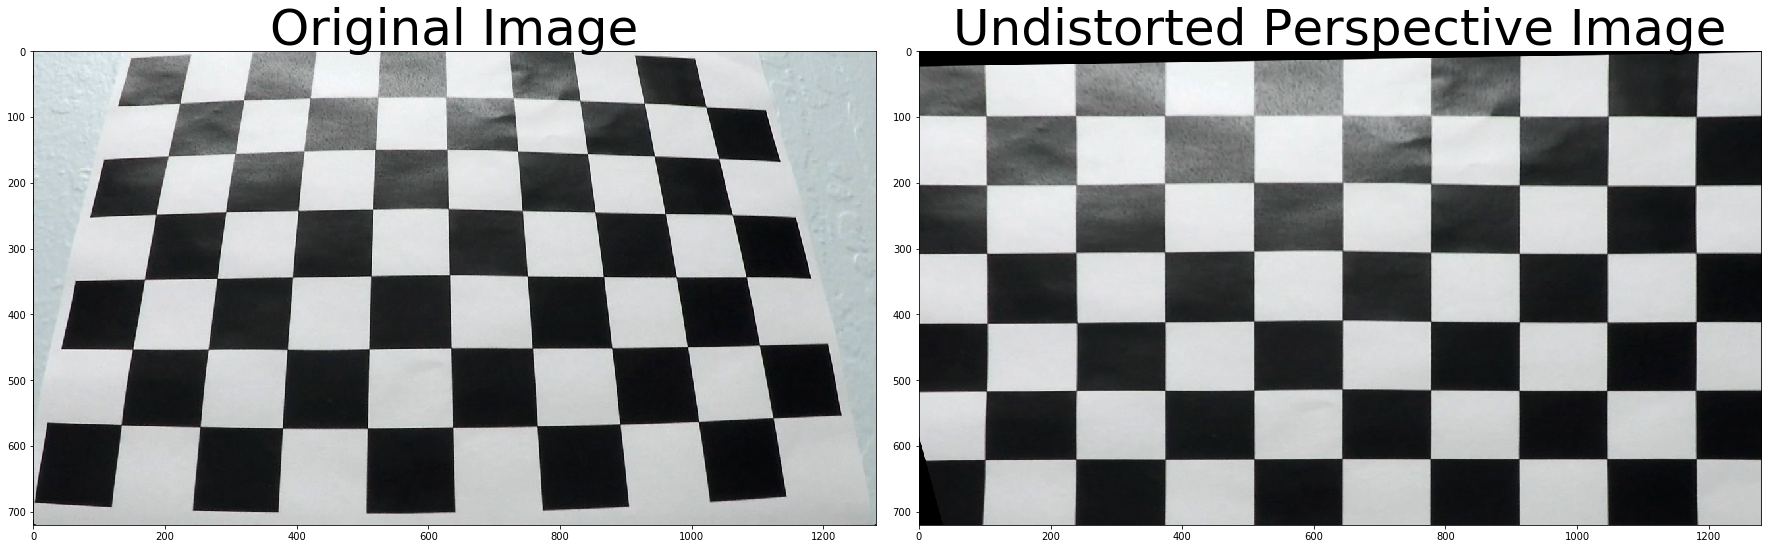

In [4]:
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Read in the saved objpoints and imgpoints
dist_pickle = pickle.load( open( "my_calib_pickle.p", "rb" ) )
objpoints = dist_pickle["objpoints"]
imgpoints = dist_pickle["imgpoints"]

# Read in an image
img = cv2.imread('camera_cal/calibration3.jpg')

# Define a function that takes an image, number of x and y points, camera matrix and distortion coefficients
def corners_unwarp(img, nx, ny, mtx, dist):
    # Use the OpenCV undistort() function to remove distortion
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    # Convert undistorted image to grayscale
    gray = cv2.cvtColor(undist, cv2.COLOR_BGR2GRAY)
    # Search for corners in the grayscaled image
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    if ret == True:        
        # Choose offset from image corners to plot detected corners
        # Arbitrarily select 100 pixels
        offset = 100 # offset for dst points
        # Get image shape
        img_size = (gray.shape[1], gray.shape[0])

        # For source points get the outer four detected corners
        src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])
        # For destination points, arbitrarily choosing points
        dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
                                     [img_size[0]-offset, img_size[1]-offset], 
                                     [offset, img_size[1]-offset]])
        # Given src and dst points, calculate the perspective transform matrix
        M = cv2.getPerspectiveTransform(src, dst)
        # Warp the image using OpenCV warpPerspective()
        warped = cv2.warpPerspective(undist, M, img_size)

    # Return the resulting image and matrix
    return warped, M

_, mtx, dist = cal_undistort(img, objpoints, imgpoints)
nx,ny = 9,6 # Redefine calib squares for testing 

undistorted,_ = corners_unwarp(img, nx, ny, mtx, dist)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Perspective Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

#### Define Road Surface Perspective Warp Function

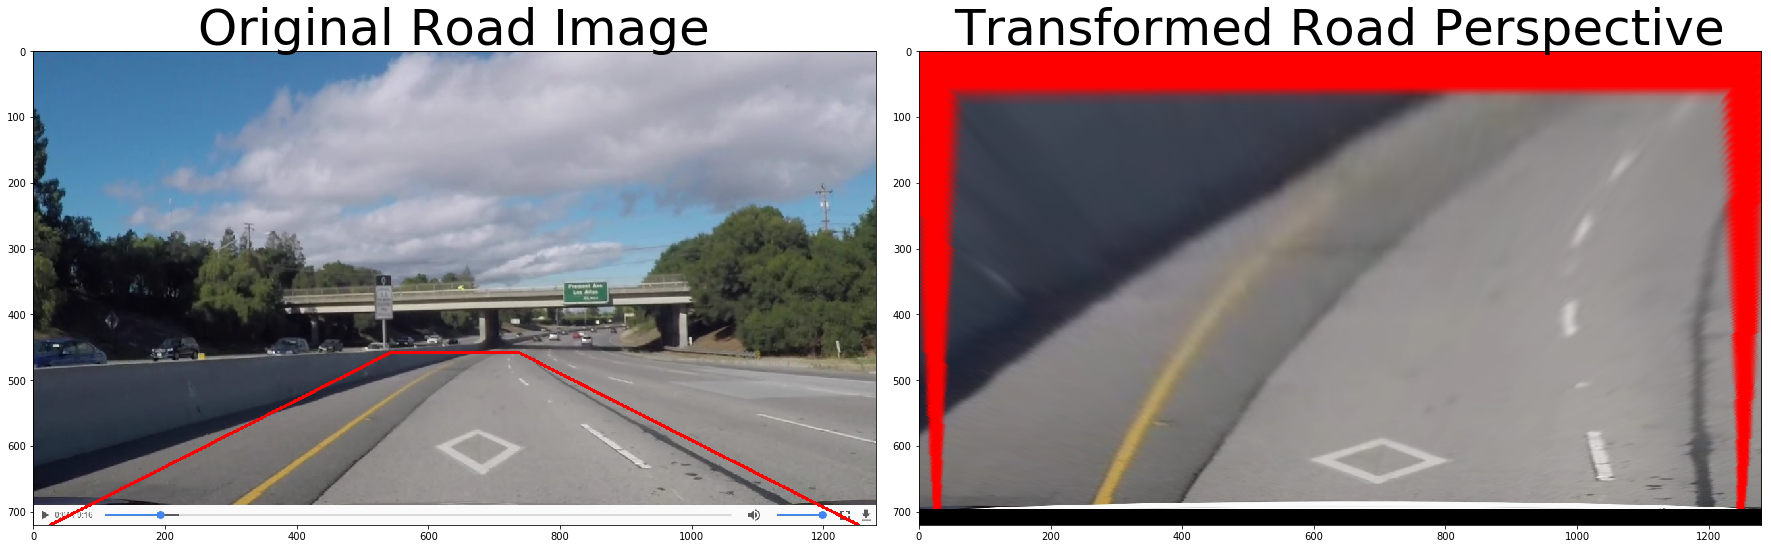

In [6]:
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.image as mpimg

# Read in the saved camera calibration data
calib_pickle = pickle.load( open( "calib_cam_params.p", "rb" ) )
mtx = calib_pickle["mtx"]
dist = calib_pickle["dst"]

# Read in an image
img = cv2.imread('test_images/challenge.jpg')
img = img[:,:,::-1] #Correcting BGR to RGB

# Define a function that takes an image, arbitrary trap mask, camera matrix and distortion coefficients
def road_unwarp(img, corners, mtx, dist, offset=25):
    # Use the OpenCV undistort() function to remove distortion
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    
    # Get image shape
    img_size = (img.shape[1], img.shape[0])

    # For source points get the outer four detected corners
    src = np.float32([corners[1], corners[2], corners[3], corners[0]])
    # For destination points
    dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
                                 [img_size[0]-offset, img_size[1]-offset], 
                                 [offset, img_size[1]-offset]])
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(undist, M, img_size)

    # Return the resulting image and matrix
    return warped,M

def roadmask(img, ApexResolution = 0.15, HorizonVert = 0.635, Nearlimit = 0.02):
    # Generate Road Mask
    # ApexResolution = 0.15 #Set percentage/100 of image for apex spread
    # HorizonVert = 0.635 #Set farfield distance (% of vertical from y=0)
    # Nearlimit = 0.05 #Set nearfield distance (% of horizontal from x=0)
    imshape = img.shape
    #Define mask vertices by using generalized limits defined above ([BL,TL,TR,BR])
    verts = np.float32([(imshape[1]*Nearlimit,imshape[0]),((1-ApexResolution)*imshape[1]*0.5, imshape[0]*HorizonVert), ((1+ApexResolution)*imshape[1]*0.5, imshape[0]*HorizonVert), (imshape[1]*(1-Nearlimit),imshape[0])])
    return verts

# Get Warped Road Plane using camera calibration data
verts = roadmask(img)

#Draw masking lines
l_color=[0, 0, 255]
thickness=3
cv2.line(img[:,:,::-1], (int(verts[0,0]), int(verts[0,1])), (int(verts[1,0]), int(verts[1,1])), l_color, thickness)
cv2.line(img[:,:,::-1], (int(verts[2,0]), int(verts[2,1])), (int(verts[3,0]), int(verts[3,1])), l_color, thickness)
cv2.line(img[:,:,::-1], (int(verts[1,0]), int(verts[1,1])), (int(verts[2,0]), int(verts[2,1])), l_color, thickness)

undistorted,_ = road_unwarp(img, verts, mtx, dist)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Road Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Transformed Road Perspective', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

#### Define Gradient Detection and Combination Functions

In [7]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    # Return the result
    return binary_output

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):    
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    abs_sobelx = np.absolute(cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    abs_sobely = np.absolute(cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    mag = np.sqrt(np.square(abs_sobelx) + np.square(abs_sobely))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*mag/np.max(mag))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    # Return the result
    return binary_output

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    abs_sobelx = np.absolute(cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    abs_sobely = np.absolute(cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    scaled_sobel = np.arctan2(abs_sobely, abs_sobelx)        
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    # Return the result
    return binary_output

def combined_sobel(image):
    # Choose a Sobel kernel size
    ksize = 3 # Choose a larger odd number to smooth gradient measurements

    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(5, 255))
    grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(5, 255))
    mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(10, 255))
    dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(0, np.pi/2))
    
    # Return combined threshold image
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    return combined

#### Create a pipeline function to generate combined image using gradients and colour spaces 

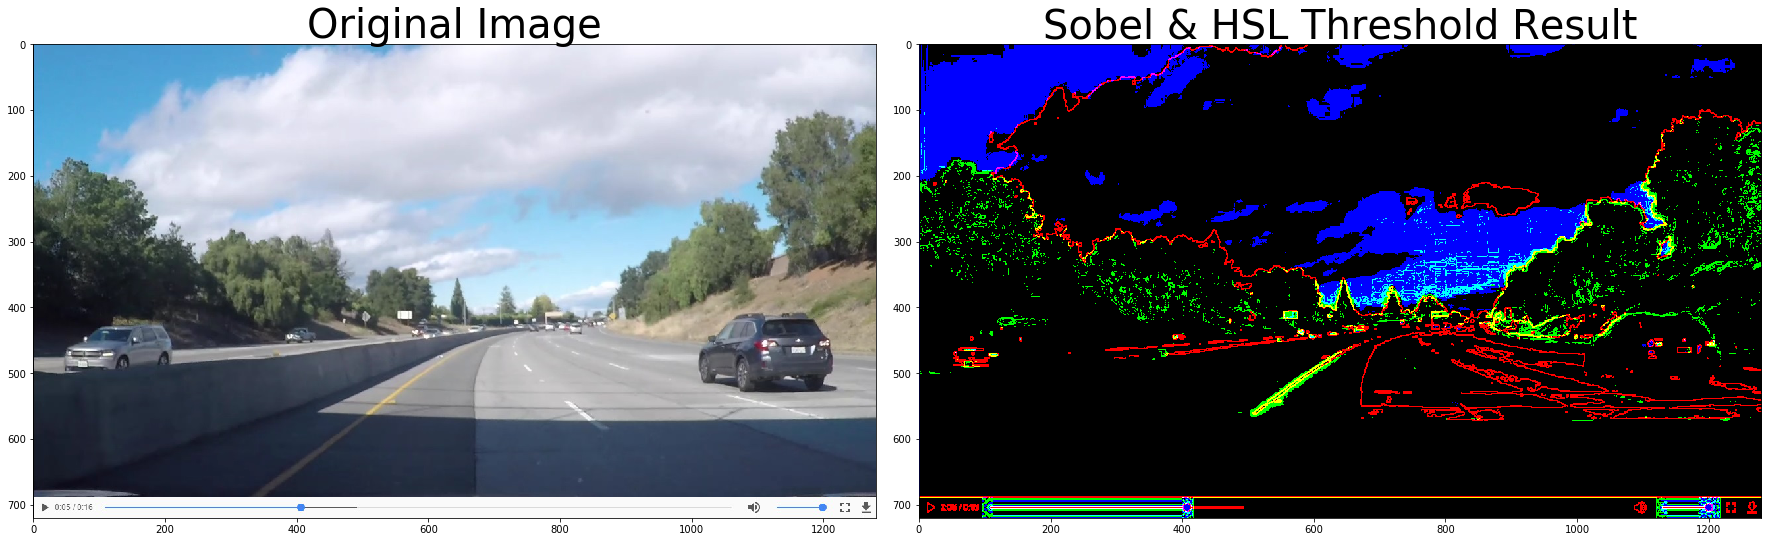

In [8]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

image = mpimg.imread('test_images/challenge3.jpg')

def colour_grad_thresh(img, s_thresh=(150, 255)):
    img = np.copy(img)
    # Convert to HSV color space and separate the HSV channels
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]
    h_channel = hsv[:,:,0]
        
    #Threshold x,y,mag Gradient by using the S Channel. Can try using l_channel and gray, but s seems best.
    sxbinary = combined_sobel(s_channel)
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    #Cancel out black lines
    sxbinary[(h_channel > 100)] = 0
    
    # Pick out white parts of image
    wbal = 180
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)    
    whitepicker = np.zeros_like(gray)    
    whitepicker[gray > wbal] = 1
    whitepicker = combined_sobel(whitepicker)
    
    # Stack each channel and return
    color_binary = np.dstack(( whitepicker, sxbinary, s_binary))
        
    return color_binary
    
result = colour_grad_thresh(image)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(image)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(result)
ax2.set_title('Sobel & HSL Threshold Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

#### Create Warped Binary Image

(720, 1280)


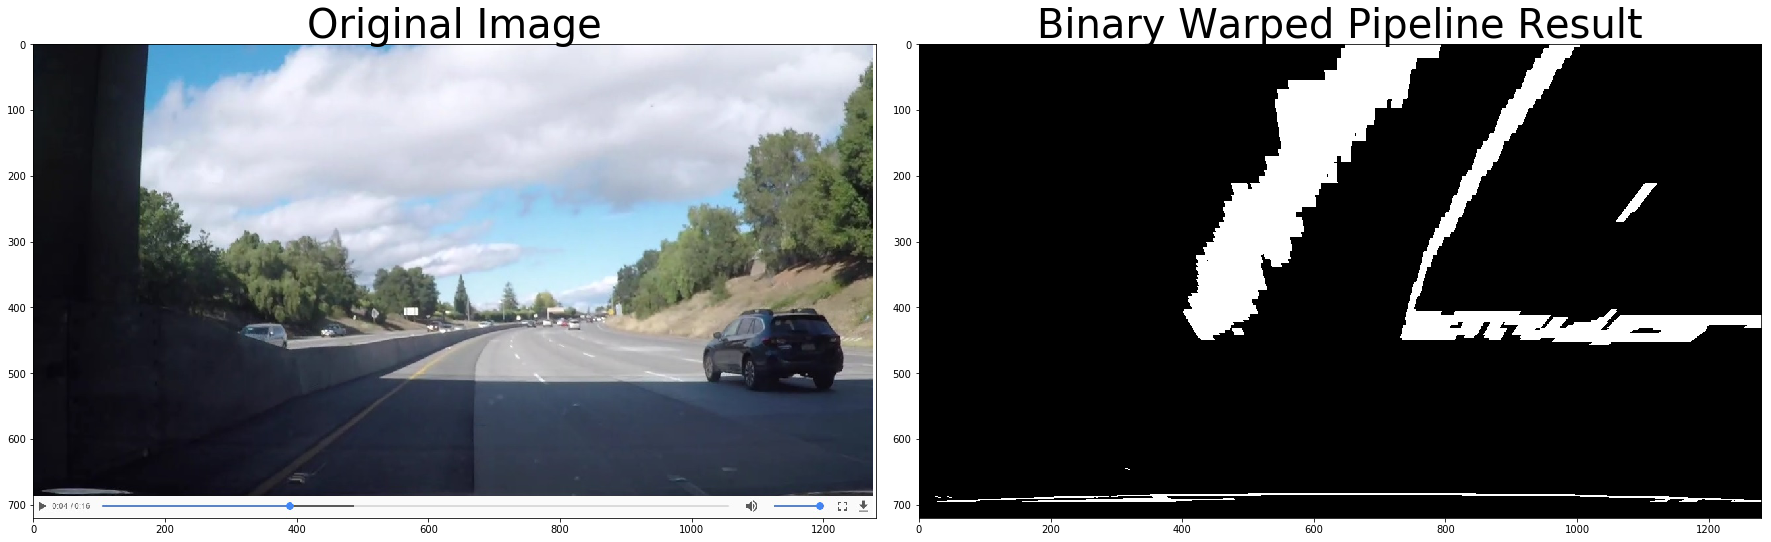

In [9]:
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.image as mpimg

# Read in the saved camera calibration data
calib_pickle = pickle.load( open( "calib_cam_params.p", "rb" ) )
mtx = calib_pickle["mtx"]
dist = calib_pickle["dst"]

# Read in an image
image = mpimg.imread('test_images/challenge2.jpg')

def binary_warp(image):
    # Takes in an image of the road and returns a binary, warped eagle-eye image
    verts = roadmask(image)

    warped = colour_grad_thresh(image, s_thresh=(150, 255))

    warped,M = road_unwarp(warped, verts, mtx, dist)

    binary_warped = np.zeros_like(warped[:,:,0])
    binary_warped[(warped[:,:,1] > 0) & (warped[:,:,1] <= 255)] = 1
    binary_warped[(warped[:,:,2] > 0) & (warped[:,:,2] <= 255)] = 1
    binary_warped[(warped[:,:,0] > 0) & (warped[:,:,0] <= 255)] = 1
    return binary_warped,M

binary_warped,M = binary_warp(image)

print(binary_warped.shape)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(image)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(binary_warped, cmap='gray')
ax2.set_title('Binary Warped Pipeline Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

#### Define a Line Class

In [50]:
# Define a class to receive the characteristics of each line detection
class Line():
    def refresh(self):        
        while (len(self.recent_xfitted) > self.n):
            self.recent_xfitted.pop(0)            
        while (len(self.poly_fits) > self.n):
            self.poly_fits.pop(0)                    
        self.bestx = np.mean(self.recent_xfitted, axis=0)
        #print(len(self.recent_xfitted))
        self.best_fit = np.mean(self.poly_fits, axis=0)
        #print(self.best_fit)
    
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None
        #y-indices for plotting
        self.ploty = None
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the n most recent fits
        self.poly_fits = []  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = 0 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = 0  
        #y values for detected line pixels
        self.ally = 0
        # radius of curvature constants
        self.ym_per_pix = 30/720
        self.xm_per_pix = 3.7/700
        # Number of iterations n to remember
        self.n = 10


#### Finding Lane Lines

Wall time: 53.5 ms


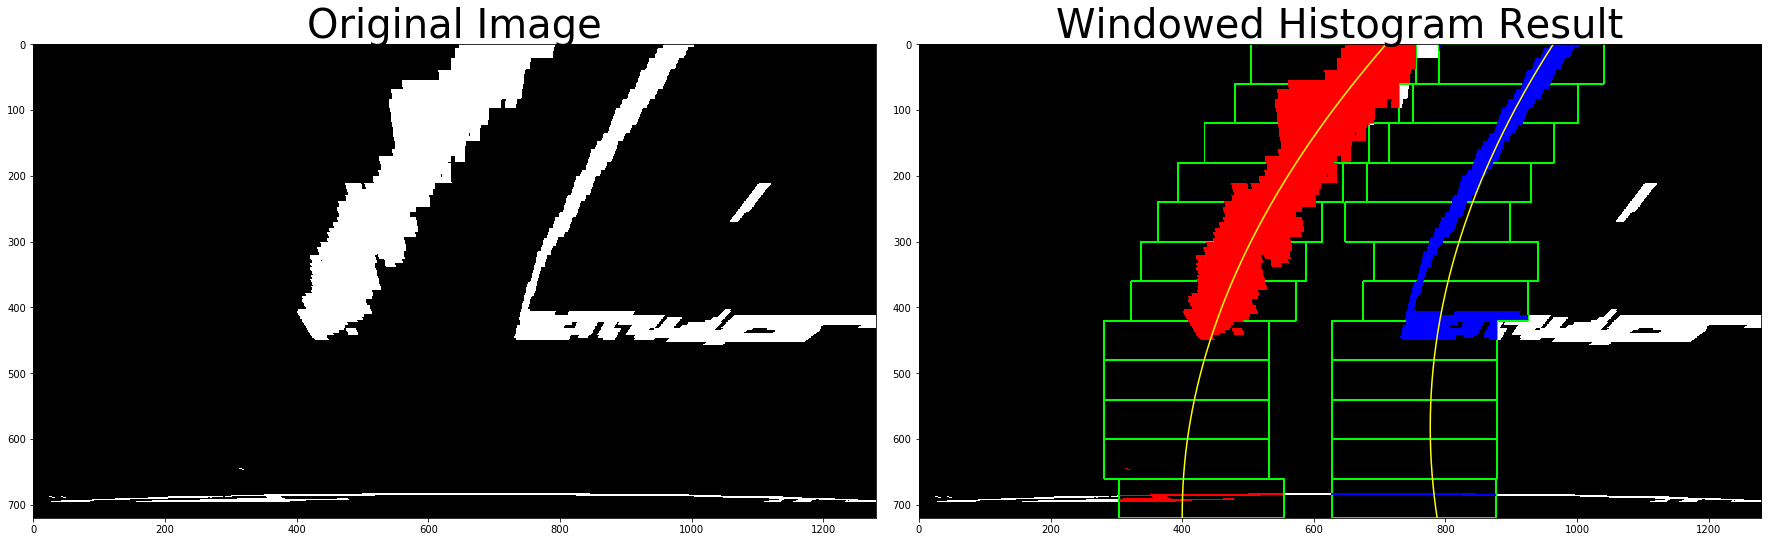

In [25]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def gen_lanefit(ypix, polynomials):
    # Generate a set of x&y points given a number of ypixels and results of np.polyfit; polynomials
    fity = np.linspace(0, ypix-1, ypix)
    fitx = polynomials[0]*fity**2 + polynomials[1]*fity + polynomials[2]
    return fitx,fity

def window_lanefind(binary_warped, _Lline, _Rline, plot=False):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    halfmark = int(binary_warped.shape[0]/2)
    histogram = np.sum(binary_warped[halfmark:,:], axis=0)
    out_img = None
    
    if (plot):
        # Create an output image to draw on and visualize the result
        out_img = np.dstack([binary_warped, binary_warped, binary_warped])*255
        out_img = np.uint8(out_img)
        #print(out_img.dtype)

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 12
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 125
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        if (plot):
            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    
    # Find bottom and right of image
    y_eval = binary_warped.shape[0]
    x_eval = binary_warped.shape[1]
    
    # Again, extract line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    
    # If indices exist, line detected, continue processing, else declare false
    if (len(leftx) > 0):
        _Lline.detected = True
                
        # Extract left and right line pixel positions
        #leftx = nonzerox[left_lane_inds]
        #lefty = nonzeroy[left_lane_inds]
        
        # Modify current x&y points in line class
        _Lline.allx = leftx
        _Lline.ally = lefty
        
        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        
        # Modify polynomial constants in line class
        _Lline.poly_fits.append(left_fit)
        
        # Generate x&y values for polyfit
        Lplotx, ploty = gen_lanefit(y_eval, left_fit)
        
        # Append xvals to list, and assign y-indices
        _Lline.recent_xfitted.append(Lplotx)
        _Lline.ploty = ploty
        
        # Fit new polynomials to x,y in world space
        left_fit_cr = np.polyfit(lefty*_Lline.ym_per_pix, leftx*_Lline.xm_per_pix, 2)
    
        # Calculate the new radii of curvature, using bottom of image as root        
        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*_Lline.ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        
        # Update Line Class with Radius of Curvature
        _Lline.radius_of_curvature = left_curverad
        
        # Refresh Line Class
        _Lline.refresh()
        
        # Update centerlane distance
        _Lline.line_base_pos = (_Lline.bestx[-1]-x_eval*0.5)*_Lline.xm_per_pix
            
    else:
        _Lline.detected = False
    
    # Repeat for Right Line
        # Again, extract line pixel positions        
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    
    if (len(rightx) > 0):
        _Rline.detected = True
        
        # Extract left and right line pixel positions
        #rightx = nonzerox[right_lane_inds]
        #righty = nonzeroy[right_lane_inds]
        
        # Modify current x&y points in line class
        _Rline.allx = rightx
        _Rline.ally = righty
        
        # Fit a second order polynomial to each
        right_fit = np.polyfit(righty, rightx, 2)
        
        # Modify polynomial constants in line class
        _Rline.poly_fits.append(right_fit)
        
        # Generate x&y values for polyfit
        Rplotx, ploty = gen_lanefit(y_eval, right_fit)
        
        # Append xvals to list, and assign y-indices
        _Rline.recent_xfitted.append(Rplotx)
        _Rline.ploty = ploty
        
        # Fit new polynomials to x,y in world space
        right_fit_cr = np.polyfit(righty*_Rline.ym_per_pix, rightx*_Rline.xm_per_pix, 2)
        
        # Calculate the new radii of curvature, using bottom of image as root   
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*_Rline.ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
        
        # Update Line Class with Radius of Curvature    
        _Rline.radius_of_curvature = right_curverad
        
        # Refresh Line Class
        _Rline.refresh()
        
        # Update centerlane distance
        _Rline.line_base_pos = (_Rline.bestx[-1]-x_eval*0.5)*_Rline.xm_per_pix
        
    else:
        _Rline.detected = False

    if (plot):
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]    
        #print(left_curverad, right_curverad)

    return _Lline,_Rline,out_img

# Initiate test lines and plot
LLineTest = Line()
RLineTest = Line()

#%time LLineTest,RLineTest,out_img = window_lanefind(binary_warped, LLineTest,RLineTest, plot=False)
%time LLineTest,RLineTest,out_img = window_lanefind(binary_warped, LLineTest,RLineTest, plot=True)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(binary_warped, cmap='gray')
ax1.set_title('Original Image', fontsize=40)
ax2.imshow(out_img)

#Lplotx, ploty = gen_lanefit(binary_warped.shape[0], LLineTest.current_fit)
#Rplotx, ploty = gen_lanefit(binary_warped.shape[0], RLineTest.current_fit)

ax2.plot(LLineTest.bestx, LLineTest.ploty, color='yellow')
ax2.plot(RLineTest.bestx, RLineTest.ploty, color='yellow')
ax2.set_title('Windowed Histogram Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

#### Assume you already have a curve fit from a previous analysis

Wall time: 113 ms


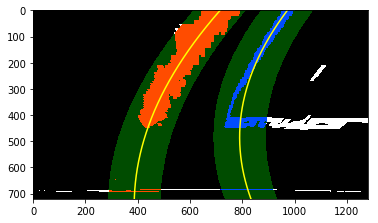

In [45]:
def cont_linesearch(binary_warped, _Lline, _Rline, plot=False):
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    left_fit = _Lline.best_fit
    right_fit = _Rline.best_fit
    
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    y_eval = binary_warped.shape[0]
    x_eval = binary_warped.shape[1]
    
    # Again, extract line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    
    # If indices exist, line detected, continue processing, else declare false
    if (len(leftx) > 0):
        _Lline.detected = True
        
        # Fit a second order polynomial
        left_fit = np.polyfit(lefty, leftx, 2)
        
        # Modify polynomial constants in line class
        _Lline.poly_fits.append(left_fit)
        
        # Generate x&y values for polyfit
        Lplotx, ploty = gen_lanefit(y_eval, left_fit)
        
        # Append xvals to list, and assign y-indices
        _Lline.recent_xfitted.append(Lplotx)
        _Lline.ploty = ploty

        # Transform to real world coordinates
        left_fit_cr = np.polyfit(lefty*_Lline.ym_per_pix, leftx*_Lline.xm_per_pix, 2)
       
        # Calculate the new radii of curvature, using bottom of image as root        
        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*_Lline.ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        
        # Update Line Class with Radius of Curvature    
        _Lline.radius_of_curvature = left_curverad
        
        #Refresh Line Class
        _Lline.refresh()
        
        # Update centerlane distance
        _Lline.line_base_pos = (_Lline.bestx[-1]-x_eval*0.5)*_Lline.xm_per_pix
        
    else:
        _Lline.detected = False
        
    # Again, extract line pixel positions        
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    
    if (len(rightx) > 0):
        _Rline.detected = True

        # Fit a second order polynomial   
        right_fit = np.polyfit(righty, rightx, 2)

        # Modify polynomial constants in line class
        _Rline.poly_fits.append(right_fit)
        
        # Generate x&y values for polyfit
        Rplotx, ploty = gen_lanefit(y_eval, right_fit)
        
        # Append xvals to list, and assign y-indices
        _Rline.recent_xfitted.append(Rplotx)
        _Rline.ploty = ploty
        
        # Transform to real world coordinates       
        right_fit_cr = np.polyfit(righty*_Rline.ym_per_pix, rightx*_Rline.xm_per_pix, 2)

        # Calculate the new radii of curvature, using bottom of image as root     
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*_Rline.ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
        
        # Update Line Class with Radius of Curvature    
        _Rline.radius_of_curvature = right_curverad
        
        # Refresh Line Class
        _Rline.refresh()
        
        # Update centerlane distance
        _Rline.line_base_pos = (_Rline.bestx[-1]-x_eval*0.5)*_Rline.xm_per_pix
        
    else:
        _Rline.detected = False    
    
    if (plot):
        # Visualize:
        # Create an image to draw on and an image to show the selection window
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        out_img = np.uint8(out_img)
        window_img = np.zeros_like(out_img)
        # Color in left and right line pixels
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_fitx = _Lline.bestx
        ploty = _Lline.ploty
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        
        right_fitx = _Rline.bestx
        ploty = _Rline.ploty
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
        plt.imshow(result)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
       
    return _Lline,_Rline

%time LLineTest, RLineTest = cont_linesearch(binary_warped, LLineTest, RLineTest, plot=True)
#%time LLineTest, RLineTest = cont_linesearch(binary_warped, LLineTest, RLineTest, plot=False)


#### Define Radius of Curvature and Center Positions Print Functions

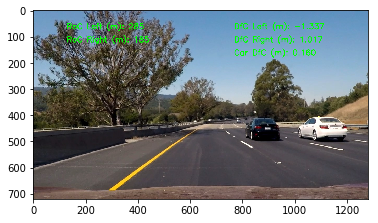

In [46]:
import cv2

def printradcurve(img, l_radius = None, r_radius = None, txtfracx = 0.1, txtfracy = 0.1, scale = 1):
    img = np.array(img)
    y = int(img.shape[0]*txtfracy)
    x = int(img.shape[1]*txtfracx)
    font = cv2.FONT_HERSHEY_SIMPLEX  
    
    if (l_radius != None):
        lstring = "RoC Left (m): "+str(int(l_radius))        
        cv2.putText(img,lstring,(x,y), font, scale,(0,255,0),2,cv2.LINE_AA)
    if (r_radius != None):        
        rstring = "RoC Right (m): "+str(int(r_radius))
        cv2.putText(img,rstring,(x,y+50), font, scale,(0,255,0),2,cv2.LINE_AA)
    return img

def printcenterpos(img, l_cent = None, r_cent = None, txtfracx = 0.6, txtfracy = 0.1, scale = 1):
    img = np.array(img)
    y = int(img.shape[0]*txtfracy)
    x = int(img.shape[1]*txtfracx)
    font = cv2.FONT_HERSHEY_SIMPLEX  
    
    if (l_cent != None):
        lstring = "DfC Left (m): "+str("{0:.3f}".format(l_cent))        
        cv2.putText(img,lstring,(x,y), font, scale,(0,255,0),2,cv2.LINE_AA)
    if (r_cent != None):
        rstring = "DfC Right (m): "+str("{0:.3f}".format(r_cent))
        cv2.putText(img,rstring,(x,y+50), font, scale,(0,255,0),2,cv2.LINE_AA)
    if (r_cent != None)&(l_cent != None):
        # If cstring is positive, center of car is to the right of lane center
        cstring = "Car DfC (m): "+str("{0:.3f}".format(-(r_cent+l_cent)/2))
        cv2.putText(img,cstring,(x,y+100), font, scale,(0,255,0),2,cv2.LINE_AA)
    return img

hudimg = printradcurve(image,l_radius = LLineTest.radius_of_curvature, r_radius = RLineTest.radius_of_curvature)
hudimg = printcenterpos(hudimg,l_cent = LLineTest.line_base_pos, r_cent = RLineTest.line_base_pos)
plt.imshow(hudimg)

#### Image Processing Pipeline

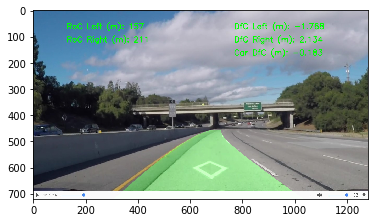

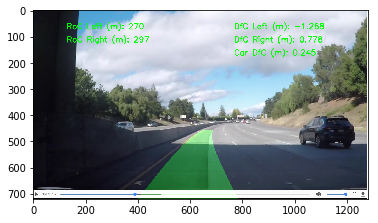

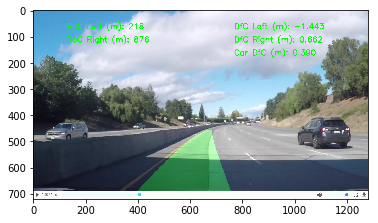

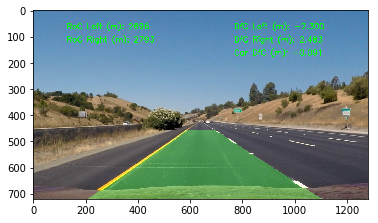

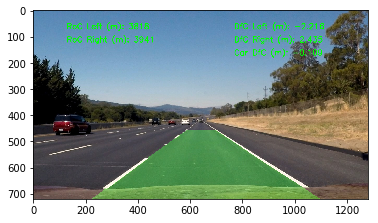

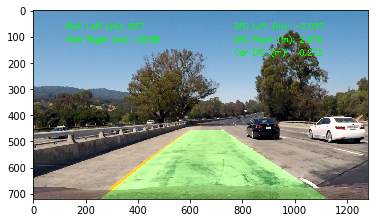

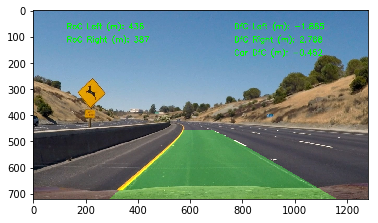

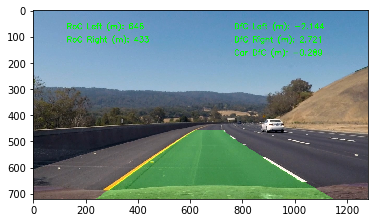

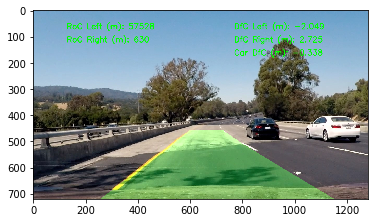

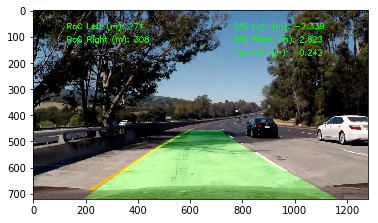

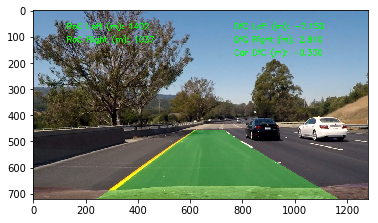

In [51]:
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.image as mpimg
from numpy.linalg import inv
import os

# Define a pipeline to process incoming images, and apply sanity checks

def lanefind_pipeline(image, LLine, RLine, plothud = True):       
        
    warped,M = binary_warp(image)    
    Minv = inv(M)
    if (LLine.detected == False) | (RLine.detected == False) | (RLine.line_base_pos < LLine.line_base_pos):
        LLine,RLine,_ = window_lanefind(warped, LLine, RLine)        
    else:
        LLine,Rline = cont_linesearch(warped, LLine, RLine)        
    
    # Reduce the smoothing for tight turns:
    if (LLine.radius_of_curvature < 100):
        LLine.n = 3
    else:
        LLine.n = 10
        
    if (RLine.radius_of_curvature < 100):
        RLine.n = 3
    else:
        RLine.n = 10
        
    RLine.refresh()
    LLine.refresh()
    
    # Use the best line fits
    left_fitx = LLine.bestx
    right_fitx = RLine.bestx    
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    ploty = LLine.ploty
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    ploty = RLine.ploty
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
    
    # Print radius curvature
    if (plothud==True):        
        result = printradcurve(result,l_radius = LLine.radius_of_curvature, r_radius = RLine.radius_of_curvature)
        result = printcenterpos(result,l_cent = LLine.line_base_pos, r_cent = RLine.line_base_pos)
    return result

# Read in an image
for testimg in os.listdir("test_images/"):
    LLine = Line() 
    RLine = Line()
    image = mpimg.imread(os.path.join('test_images/',testimg)) 
    result = lanefind_pipeline(image,LLine,RLine)
    plt.imshow(result)
    plt.figure()

#### Movie Test

In [48]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

def process_image(image):    
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)    
    result = lanefind_pipeline(image, LLine, RLine)
    
    return result


#### Process Main Test Video

In [52]:
LLine = Line() 
RLine = Line()

white_output = 'my_test.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video my_test.mp4
[MoviePy] Writing video my_test.mp4



100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [08:25<00:00,  2.47it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: my_test.mp4 

Wall time: 8min 25s


#### Play Main Test Video

In [53]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

#### Try Harder Challenge Videos

In [54]:
LLine = Line() 
RLine = Line()

challenge_output = 'my_challenge_video.mp4'
clip1 = VideoFileClip("challenge_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video my_challenge_video.mp4
[MoviePy] Writing video my_challenge_video.mp4



100%|████████████████████████████████████████████████████████████████████████████████| 485/485 [03:08<00:00,  2.57it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: my_challenge_video.mp4 

Wall time: 3min 8s


In [55]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))

In [56]:
LLine = Line() 
RLine = Line()

challenge2_output = 'my_harder_challenge_video.mp4'
clip1 = VideoFileClip("harder_challenge_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(challenge2_output, audio=False)

[MoviePy] >>>> Building video my_harder_challenge_video.mp4
[MoviePy] Writing video my_harder_challenge_video.mp4



100%|█████████████████████████████████████████████████████████████████████████████▉| 1199/1200 [08:35<00:00,  2.35it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: my_harder_challenge_video.mp4 

Wall time: 8min 36s


In [57]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge2_output))